In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [5]:
# This cell is only here as a bug fix when running RNN on my GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Prepare data

## Load dataset

In [159]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

# Used to train fit tokenizer
#all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

train_labels = np.array(data["train_set"]['polarity'])
val_labels = np.array(data["val_set"]['polarity'])
test_labels = np.array(data["test_set"]['polarity'])
class_names = data['class_names']

## Preprocess dataset

### Tokenize

We train the tokenizer on the reviews of the train set

In [160]:
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 186308 unique tokens.


In [161]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_reviews)
val_reviews_tokenized = tokenizer.texts_to_sequences(val_reviews)
test_reviews_tokenized = tokenizer.texts_to_sequences(test_reviews)

In [162]:
some_review = train_reviews_tokenized[0]
some_review[:15]

[45, 68, 4664, 17, 77, 15081, 7, 80, 9, 8746, 2505, 249, 439, 17, 1181]

In [163]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in some_review[:15]])

"si vous cherchez du cinéma abrutissant à tous les étages n'ayant aucune peur du cliché"

Average length: 91.5
Max length: 389


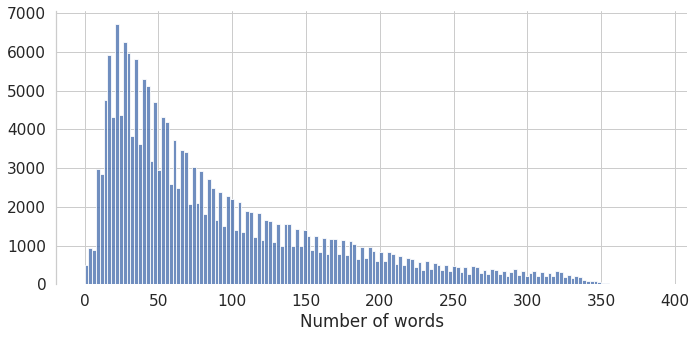

In [164]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_words.png', dpi=200)

In [165]:
# This assert is likely to fail
assert(reviews_len.count(0) == 0)

AssertionError: 

### Remove empty sequences

Important not to have empty tensors: https://github.com/tensorflow/tensorflow/issues/33148

In [166]:
def remove_empty_sequences(reviews, labels):
    reviews_not_empty = []
    labels_not_empty = []
    removed = 0
    for x, y in zip(reviews, labels):
        if len(x) > 0:
            reviews_not_empty.append(x)
            labels_not_empty.append(y)
        else:
            removed += 1
    #print("Removed {} sequences !".format(removed))
    return reviews_not_empty, labels_not_empty

In [167]:
print('Removing {} empty sequences'.format(reviews_len.count(0)))

train_reviews_tokenized, train_labels = remove_empty_sequences(
    train_reviews_tokenized, train_labels
)

val_reviews_tokenized, val_labels = remove_empty_sequences(
    val_reviews_tokenized, val_labels
)

test_reviews_tokenized, test_labels = remove_empty_sequences(
    test_reviews_tokenized, test_labels
)

# Verify
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
assert(reviews_len.count(0) == 0)

Removing 8 empty sequences


### Padding

Then we pad short sequences with zeros until they reach a fixed length. Long sequences are also truncated.

In [168]:
MAX_LENGTH_SEQ = 350 #

X_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = tf.keras.preprocessing.sequence.pad_sequences(
    val_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (159993, 350)
Shape of X_val tensor: (19999, 350)
Shape of X_test tensor: (20000, 350)


### Labels

In [169]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

### Preprocessing pipeline

In order to carry out the preprocessing phase more efficiently, we can define a Scikit-Learn transformer.

In [130]:
from sklearn.base import BaseEstimator, TransformerMixin

class SequencePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_nbr_words, max_seq_length):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_nbr_words,
            oov_token="<unk>",
        )
        self.max_seq_length = max_seq_length

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X):
        self.tokenizer.fit_on_texts(X)

    def transform(self, X, y):
        # 1. Tokenize
        X_tokenized = self.tokenizer.texts_to_sequences(X)
        # 2. Remove empty sequences
        X_not_empty, y_not_empty = remove_empty_sequences(X_tokenized, y)
        # 3. Pad
        X_padded = tf.keras.preprocessing.sequence.pad_sequences(
            X_not_empty, 
            maxlen=self.max_seq_length,
            padding='post'
        )
        # 4. labels
        y_array = np.array(y_not_empty)
        return X_padded, y_array     
    
    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X, y)

# Averaging embeddings

## Model

First we train an model which classify reviews based on the average vector of their embeddings.

In [94]:
from tensorflow import keras
from tensorflow.keras import layers

max_features = MAX_NB_WORDS
embedding_dim = 128

model = keras.models.Sequential(name='average')
model.add(layers.Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [95]:
initial_weights = model.get_weights()
model.summary()

Model: "average"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
_________________________________________________________________


## Training

In [61]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/average_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128, 
    callbacks=[checkpointer], verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/10
159872/159993 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.8217
Epoch 00001: val_loss improved from inf to 0.29829, saving model to /tmp/average_weights.hdf5
159993/159993 [==============================] - 28s 177us/sample - loss: 0.4678 - accuracy: 0.8218 - val_loss: 0.2983 - val_accuracy: 0.9049
Epoch 2/10
159872/159993 [============================>.] - ETA: 0s - loss: 0.2547 - accuracy: 0.9123
Epoch 00002: val_loss improved from 0.29829 to 0.22919, saving model to /tmp/average_weights.hdf5
159993/159993 [==============================] - 28s 172us/sample - loss: 0.2546 - accuracy: 0.9123 - val_loss: 0.2292 - val_accuracy: 0.9193
Epoch 3/10
159872/159993 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9267
Epoch 00003: val_loss improved from 0.22919 to 0.20834, saving model to /tmp/average_weights.hdf5
159993/159993 [==============================] - 28s 174us/sample - l

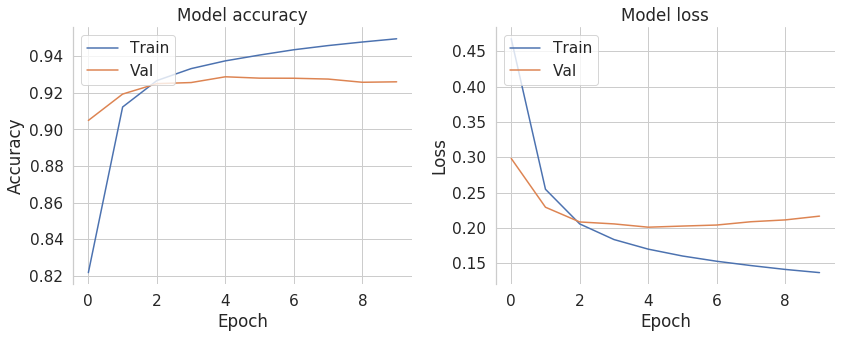

In [62]:
from utils import plot_training_curves

fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/average_training.png', dpi=200)

In [63]:
from sklearn import metrics

model.load_weights('/tmp/average_weights.hdf5')
probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Val Accuracy: 92.88
Val F1-Score: 92.75


This simple technique works surprisingly well on our task !

## Testing

In [64]:
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [65]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 92.90
Test F1-Score: 92.57

              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93     10408
    Positive       0.93      0.92      0.93      9592

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



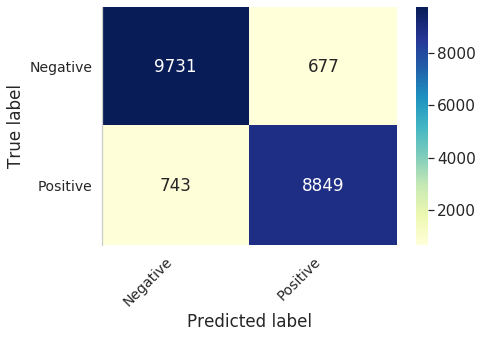

In [66]:
from sklearn.metrics import confusion_matrix
from utils import print_confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/average_test_confusion_mx.png', dpi=200)

## Accuracy vs Training data

In [131]:
from sklearn.base import BaseEstimator

class EarlyStoppingModel(BaseEstimator):
    def __init__(self, keras_model, max_epoches, batch_size, validation_data):
        self.model = keras_model
        self.max_epoches = max_epoches
        self.batch_size = batch_size
        self.validation_data = validation_data
        
    def fit(self, X, y):
        # Defines early stopper
        early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', mode='auto', patience=2,
            verbose=1, restore_best_weights=True
        )
        
        # Train model on data subset
        self.model.fit(
            X, y,
            validation_data=self.validation_data,
            epochs=self.max_epoches, 
            batch_size=self.batch_size,
            callbacks=[early_stopper], 
            verbose=2
        )        
        return self
    
    def predict(self, X):        
        probas = self.model.predict(X)
        y_pred = (probas > 0.5).astype(np.int)
        return y_pred

In [135]:
from sklearn import metrics 

def accuracy_vs_training_data(keras_model, initial_weights, 
                              preprocessor, sizes,
                              train_reviews, train_labels,
                              val_reviews, val_labels,
                              test_reviews, test_labels):
    test_accuracies = []
    for size in sizes:        
        # Preprocess data
        X_train, y_train = preprocessor.fit_transform(
            train_reviews[:size], train_labels[:size]
        )
        X_val, y_val = preprocessor.transform(val_reviews, val_labels)
        X_test, y_test = preprocessor.transform(test_reviews, test_labels)
        
        # Reset weights to initial value
        keras_model.set_weights(initial_weights)
        best_model = EarlyStoppingModel(
            keras_model, max_epoches=100, batch_size=64,
            validation_data=(X_val, y_val)
        )
        
        # Train model
        best_model.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_accuracies.append(test_acc)
        
    return test_accuracies        

In [136]:
sizes = [1000, 5000, 10000, 20000, 40000, 80000, 120000, 160000]
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)

Train on 1000 samples, validate on 19998 samples
Epoch 1/100
1000/1000 - 1s - loss: 0.6923 - accuracy: 0.5180 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 2/100
1000/1000 - 1s - loss: 0.6898 - accuracy: 0.5440 - val_loss: 0.6900 - val_accuracy: 0.5455
Epoch 3/100
1000/1000 - 1s - loss: 0.6871 - accuracy: 0.5610 - val_loss: 0.6887 - val_accuracy: 0.5489
Epoch 4/100
1000/1000 - 1s - loss: 0.6845 - accuracy: 0.5740 - val_loss: 0.6872 - val_accuracy: 0.5541
Epoch 5/100
1000/1000 - 1s - loss: 0.6813 - accuracy: 0.6200 - val_loss: 0.6854 - val_accuracy: 0.5774
Epoch 6/100
1000/1000 - 1s - loss: 0.6772 - accuracy: 0.6440 - val_loss: 0.6834 - val_accuracy: 0.5776
Epoch 7/100
1000/1000 - 1s - loss: 0.6730 - accuracy: 0.6510 - val_loss: 0.6811 - val_accuracy: 0.5836
Epoch 8/100
1000/1000 - 1s - loss: 0.6680 - accuracy: 0.6600 - val_loss: 0.6786 - val_accuracy: 0.5897
Epoch 9/100
1000/1000 - 1s - loss: 0.6627 - accuracy: 0.6720 - val_loss: 0.6755 - val_accuracy: 0.5940
Epoch 10/100
1000/1000 -

Epoch 80/100
1000/1000 - 1s - loss: 0.1014 - accuracy: 0.9870 - val_loss: 0.3915 - val_accuracy: 0.8456
Epoch 81/100
1000/1000 - 1s - loss: 0.0996 - accuracy: 0.9900 - val_loss: 0.3906 - val_accuracy: 0.8421
Epoch 82/100
1000/1000 - 1s - loss: 0.0978 - accuracy: 0.9880 - val_loss: 0.3892 - val_accuracy: 0.8448
Epoch 83/100
1000/1000 - 1s - loss: 0.0954 - accuracy: 0.9890 - val_loss: 0.3895 - val_accuracy: 0.8422
Epoch 84/100
1000/1000 - 1s - loss: 0.0935 - accuracy: 0.9910 - val_loss: 0.3882 - val_accuracy: 0.8446
Epoch 85/100
1000/1000 - 1s - loss: 0.0921 - accuracy: 0.9880 - val_loss: 0.3881 - val_accuracy: 0.8459
Epoch 86/100
1000/1000 - 1s - loss: 0.0902 - accuracy: 0.9900 - val_loss: 0.3876 - val_accuracy: 0.8433
Epoch 87/100
1000/1000 - 1s - loss: 0.0882 - accuracy: 0.9900 - val_loss: 0.3869 - val_accuracy: 0.8455
Epoch 88/100
1000/1000 - 1s - loss: 0.0870 - accuracy: 0.9890 - val_loss: 0.3867 - val_accuracy: 0.8443
Epoch 89/100
1000/1000 - 1s - loss: 0.0851 - accuracy: 0.9910 - 

19999/19999 - 6s - loss: 0.6168 - accuracy: 0.7623 - val_loss: 0.5475 - val_accuracy: 0.8118
Epoch 3/100
19999/19999 - 6s - loss: 0.4661 - accuracy: 0.8661 - val_loss: 0.4104 - val_accuracy: 0.8814
Epoch 4/100
19999/19999 - 6s - loss: 0.3537 - accuracy: 0.8955 - val_loss: 0.3406 - val_accuracy: 0.8945
Epoch 5/100
19999/19999 - 6s - loss: 0.2874 - accuracy: 0.9173 - val_loss: 0.2998 - val_accuracy: 0.9030
Epoch 6/100
19999/19999 - 6s - loss: 0.2435 - accuracy: 0.9285 - val_loss: 0.2760 - val_accuracy: 0.9072
Epoch 7/100
19999/19999 - 6s - loss: 0.2129 - accuracy: 0.9374 - val_loss: 0.2623 - val_accuracy: 0.9076
Epoch 8/100
19999/19999 - 6s - loss: 0.1892 - accuracy: 0.9446 - val_loss: 0.2516 - val_accuracy: 0.9109
Epoch 9/100
19999/19999 - 6s - loss: 0.1704 - accuracy: 0.9503 - val_loss: 0.2450 - val_accuracy: 0.9114
Epoch 10/100
19999/19999 - 6s - loss: 0.1537 - accuracy: 0.9563 - val_loss: 0.2410 - val_accuracy: 0.9120
Epoch 11/100
19999/19999 - 6s - loss: 0.1401 - accuracy: 0.9590 - 

In [137]:
import pickle

OUTPUT_PATH = 'data/average_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

# Simple RNN

## Model

In [173]:
from tensorflow import keras
from tensorflow.keras import layers

embedding_dim = 128

model = keras.models.Sequential(name='rnn')
model.add(layers.Embedding(MAX_NB_WORDS, embedding_dim,
                           mask_zero=True,                           
                           input_shape=[None]),)

model.add(layers.GRU(256, return_sequences=True))
model.add(layers.GRU(256))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [174]:
initial_weights = model.get_weights()
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
gru_12 (GRU)                 (None, None, 256)         296448    
_________________________________________________________________
gru_13 (GRU)                 (None, 256)               394752    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 3,251,457
Trainable params: 3,251,457
Non-trainable params: 0
_________________________________________________________________


## Training

In [175]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/rnn_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=64, 
    callbacks=[checkpointer], verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9126
Epoch 00001: val_loss improved from inf to 0.17517, saving model to /tmp/rnn_weights.hdf5
159993/159993 [==============================] - 134s 839us/sample - loss: 0.2158 - accuracy: 0.9126 - val_loss: 0.1752 - val_accuracy: 0.9324
Epoch 2/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9550
Epoch 00002: val_loss improved from 0.17517 to 0.15195, saving model to /tmp/rnn_weights.hdf5
159993/159993 [==============================] - 131s 819us/sample - loss: 0.1215 - accuracy: 0.9550 - val_loss: 0.1519 - val_accuracy: 0.9439
Epoch 3/5
159936/159993 [============================>.] - ETA: 0s - loss: 0.0827 - accuracy: 0.9707
Epoch 00003: val_loss did not improve from 0.15195
159993/159993 [==============================] - 131s 819us/sample - loss: 0.0827 - accuracy: 0.9707 - val_loss: 0.1714 - val

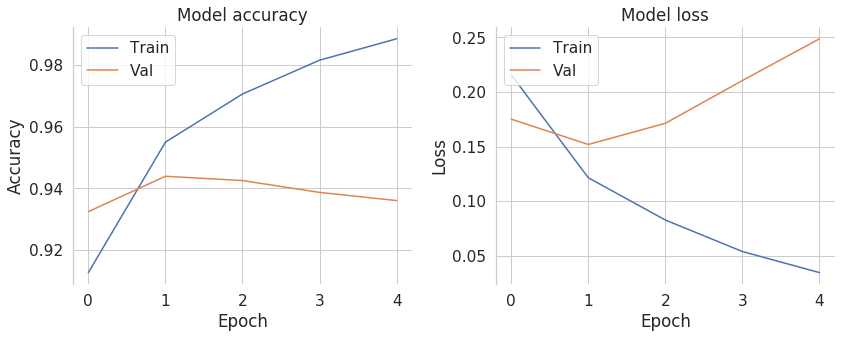

In [176]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/rnn_training.png', dpi=200)

RNN seems to overfit very quickly, but the validation accuracy of the very firsts epoches is quite good !

In [177]:
from sklearn import metrics

model.load_weights('/tmp/rnn_weights.hdf5')
probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Val Accuracy: 94.39
Val F1-Score: 94.34


## Testing

In [178]:
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [179]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 94.58
Test F1-Score: 94.39

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95     10408
    Positive       0.94      0.95      0.94      9592

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



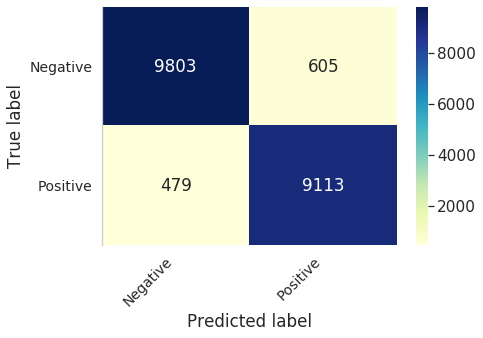

In [180]:
from sklearn.metrics import confusion_matrix
from utils import print_confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/rnn_test_confusion_mx.png', dpi=200)

## Accuracy vs Training data

In [140]:
sizes = [1000, 5000, 10000, 20000, 40000, 80000, 120000, 160000]
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)

Train on 1000 samples, validate on 19998 samples
Epoch 1/100
1000/1000 - 10s - loss: 0.6912 - accuracy: 0.5280 - val_loss: 0.6767 - val_accuracy: 0.6088
Epoch 2/100
1000/1000 - 6s - loss: 0.4740 - accuracy: 0.7850 - val_loss: 0.6038 - val_accuracy: 0.6976
Epoch 3/100
1000/1000 - 6s - loss: 0.1278 - accuracy: 0.9530 - val_loss: 0.6769 - val_accuracy: 0.6943
Epoch 4/100
Restoring model weights from the end of the best epoch.
1000/1000 - 6s - loss: 0.0426 - accuracy: 0.9880 - val_loss: 1.2740 - val_accuracy: 0.7154
Epoch 00004: early stopping
Train on 5000 samples, validate on 19998 samples
Epoch 1/100
5000/5000 - 9s - loss: 0.6472 - accuracy: 0.6096 - val_loss: 0.4615 - val_accuracy: 0.8239
Epoch 2/100
5000/5000 - 10s - loss: 0.3046 - accuracy: 0.8804 - val_loss: 0.3498 - val_accuracy: 0.8533
Epoch 3/100
5000/5000 - 9s - loss: 0.0761 - accuracy: 0.9708 - val_loss: 0.4354 - val_accuracy: 0.8460
Epoch 4/100
Restoring model weights from the end of the best epoch.
5000/5000 - 9s - loss: 0.03

In [141]:
import pickle

OUTPUT_PATH = 'data/rnn_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

# Bidirectional RNN

In [ ]:
# TODO

# CNN

Here we implement [this model](https://arxiv.org/abs/1412.1058), because it has a pretty good accuracy on the english IMDB sentiment analysis dataset.

## Model

In [40]:
emb_dim = 512
hid_dim = 512
sentence_length = MAX_LENGTH_SEQ
num_words = MAX_NB_WORDS
dropout_rate = 0.05
    
input_layer = tf.keras.layers.Input(shape=(sentence_length,), dtype=tf.int32)

layer = tf.keras.layers.Embedding(num_words, output_dim=emb_dim)(input_layer)

layer_conv3 = tf.keras.layers.Conv1D(hid_dim, 3, activation="relu")(layer)
layer_conv3 = tf.keras.layers.GlobalMaxPooling1D()(layer_conv3)

layer_conv4 = tf.keras.layers.Conv1D(hid_dim, 2, activation="relu")(layer)
layer_conv4 = tf.keras.layers.GlobalMaxPooling1D()(layer_conv4)

layer = tf.keras.layers.concatenate([layer_conv4, layer_conv3], axis=1)
layer = tf.keras.layers.BatchNormalization()(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)

output = tf.keras.layers.Dense(1, activation="sigmoid")(layer)

model = tf.keras.models.Model(name='cnn', inputs=[input_layer], outputs=output)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [41]:
initial_weights = model.get_weights()
model.summary()

Model: "cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 350, 512)     10240000    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 349, 512)     524800      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 348, 512)     786944      embedding_6[0][0]                
________________________________________________________________________________________________

## Training

In [42]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/cnn_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=128, 
    callbacks=[checkpointer], verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9212
Epoch 00001: val_loss improved from inf to 0.15319, saving model to /tmp/cnn_weights.hdf5
159993/159993 [==============================] - 222s 1ms/sample - loss: 0.1963 - accuracy: 0.9212 - val_loss: 0.1532 - val_accuracy: 0.9416
Epoch 2/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9696
Epoch 00002: val_loss did not improve from 0.15319
159993/159993 [==============================] - 222s 1ms/sample - loss: 0.0854 - accuracy: 0.9696 - val_loss: 0.1911 - val_accuracy: 0.9314
Epoch 3/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9846
Epoch 00003: val_loss did not improve from 0.15319
159993/159993 [==============================] - 223s 1ms/sample - loss: 0.0443 - accuracy: 0.9846 - val_loss: 0.2280 - val_accuracy: 0.9295
Epoch 4/5
159872/159993 [======

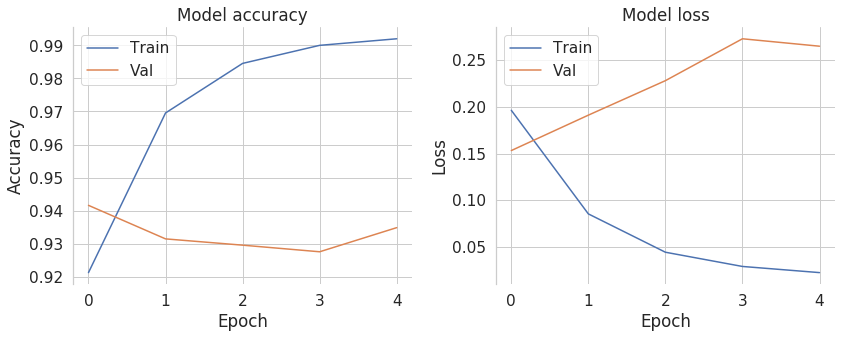

In [43]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/cnn_training.png', dpi=200)

In [45]:
from sklearn import metrics

model.load_weights('/tmp/cnn_weights.hdf5')
probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Val Accuracy: 94.16
Val F1-Score: 94.11


## Testing

In [49]:
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [52]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 94.38
Test F1-Score: 94.18

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95     10408
    Positive       0.94      0.95      0.94      9592

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



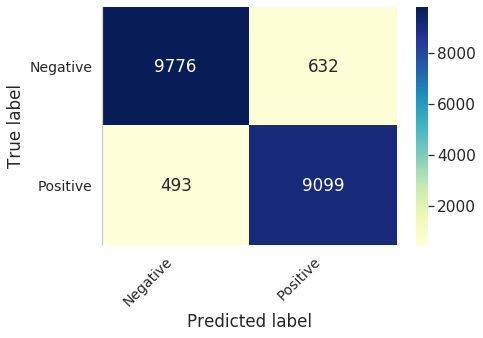

In [55]:
from sklearn.metrics import confusion_matrix
from utils import print_confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/cnn_test_confusion_mx.png', dpi=200)

# fastText

In [ ]:
# TODO: delete
# implement a subword fasttext model in another notebook

[fastText classifier](https://fasttext.cc/docs/en/supervised-tutorial.html) works by averaging learned word embeddings. This is exactly what we did for our first model !

However, fastText go further by using n-gram word embeddings. Let's see if we can get better results by using bi-grams !

## Adding bigrams

In [31]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])

        new_sequences.append(new_list)

    return new_sequences

def augment_dataset(train_reviews, val_reviews, test_reviews, max_features, ngram_range):
    assert(ngram_range > 1)  
    
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in train_reviews:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1    

    # Augmenting x_train and x_test with n-grams features
    train_ngram = add_ngram(train_reviews, token_indice, ngram_range)
    val_ngram = add_ngram(val_reviews, token_indice, ngram_range)
    test_ngram = add_ngram(test_reviews, token_indice, ngram_range)
    
    return train_ngram, val_ngram, test_ngram, max_features  

In [32]:
ngram_range = 2

print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.

train_ngram, val_ngram, test_ngram, max_ngram_features = augment_dataset(
    train_reviews_tokenized, val_reviews_tokenized, test_reviews_tokenized, 
    MAX_NB_WORDS, ngram_range
)

print('From {} to {} features.'.format(
    MAX_NB_WORDS, max_ngram_features
))

Adding 2-gram features
From 20000 to 367960 features.


Average length: 174.3
Max length: 727


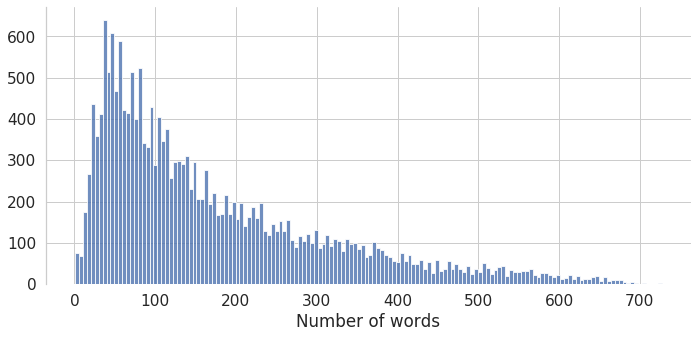

In [33]:
reviews_len = [len(s) for s in train_ngram+val_ngram+test_ngram]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_bigrams.png', dpi=200)

## Padding

In [34]:
MAX_LENGTH_SEQ = 700

# truncate long sequences and pad short sequences with 0s
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_ngram, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = tf.keras.preprocessing.sequence.pad_sequences(
    val_ngram, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_ngram, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (12000, 700)
Shape of X_val tensor: (4000, 700)
Shape of X_test tensor: (4000, 700)


In [35]:
from tensorflow import keras
from tensorflow.keras import layers

embedding_dim = 128
max_features = max_ngram_features

model = keras.models.Sequential(name="fastText")
model.add(layers.Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [36]:
model.summary()

Model: "fastText"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         47098880  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 47,099,009
Trainable params: 47,099,009
Non-trainable params: 0
_________________________________________________________________


## Training

In [37]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/fasttext_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=32, 
    callbacks=[checkpointer], verbose=1)

Train on 12000 samples, validate on 4000 samples
Epoch 1/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6166
Epoch 00001: val_loss improved from inf to 0.65291, saving model to /tmp/fasttext_weights.hdf5
12000/12000 [==============================] - 123s 10ms/sample - loss: 0.6789 - accuracy: 0.6167 - val_loss: 0.6529 - val_accuracy: 0.7308
Epoch 2/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.5707 - accuracy: 0.8227
Epoch 00002: val_loss improved from 0.65291 to 0.51335, saving model to /tmp/fasttext_weights.hdf5
12000/12000 [==============================] - 124s 10ms/sample - loss: 0.5705 - accuracy: 0.8230 - val_loss: 0.5133 - val_accuracy: 0.8600
Epoch 3/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.9072
Epoch 00003: val_loss improved from 0.51335 to 0.40840, saving model to /tmp/fasttext_weights.hdf5
12000/12000 [==============================] - 135s 11ms/sample - loss: 0.4053

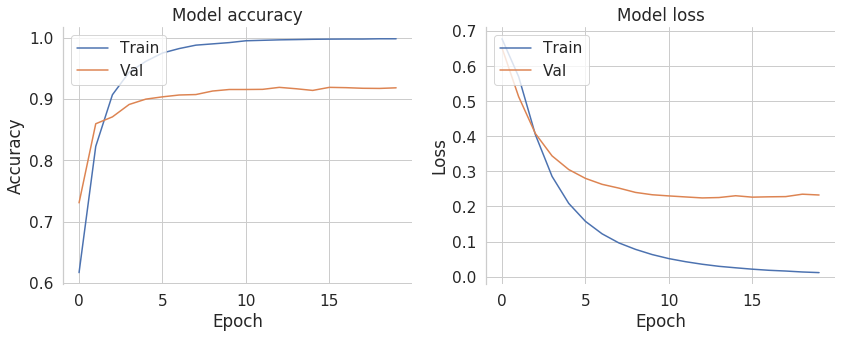

In [38]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/fasttext_training.png', dpi=200)

In [39]:
model.load_weights('/tmp/fasttext_weights.hdf5')
probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(metrics.f1_score(y_val, y_pred)))

Val Accuracy: 0.92
Val F1-Score: 0.92


## Testing best fastText model

In [40]:
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [41]:
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 0.91
Test F1-Score: 0.91

              precision    recall  f1-score   support

    Negative       0.90      0.91      0.91      1988
    Positive       0.91      0.91      0.91      2012

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



In [138]:
# TODO: test RNN & CNN on smaller part of the dataset, (accuracy as a function of dataset size) as RNN should decrease in accuracy with a smaller dataset